In [1]:
import numpy as np
import pandas as pd

In [2]:
#function that prints some general stats of a dataframe
def print_stats_df(df, name=''):
    n_tweets = len(df)
    print('GENERAL STATS '+name)
    print('number of tweets:', n_tweets)
    print('number of unique media:', df['present_media'].nunique() )
    print('number of unique language:', df['language'].nunique() )
    print('number of unique EWUF users:', df["engaged_with_user_id"].nunique() )
    print('number of unique EUF users:', df["enaging_user_id"].nunique() )

    labels = ["reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
    is_y = all([label in df.columns for label in labels])
    if is_y:
        print('\nNUMBER OF ENGAGEMENTS '+name)
        print('number of replies:',n_tweets - df['reply_timestamp'].isna().sum(), (n_tweets - df['reply_timestamp'].isna().sum())/n_tweets)
        print('number of retweets:', n_tweets - df['retweet_timestamp'].isna().sum(), (n_tweets - df['retweet_timestamp'].isna().sum() )/n_tweets )
        print('number of retweet comments:',n_tweets - df["retweet_with_comment_timestamp"].isna().sum(), (n_tweets - df["retweet_with_comment_timestamp"].isna().sum())/n_tweets)
        print('number of likes',n_tweets - df['like_timestamp'].isna().sum(), (n_tweets - df['like_timestamp'].isna().sum())/n_tweets)
    print('------------------------------------------------------------')  
    print()    


In [3]:
from sklearn.preprocessing import StandardScaler
import re

class TwitterTransform:
    """takes a df and cleans it to be used as input of a model in matrix form"""
    
    def __init__(self, lang_tol=0):

        self.ss = StandardScaler()
        self.lang_tol = lang_tol
        self.list_languages = []
        self.selection_to_standarize = ["engaged_with_user_follower_count","engaged_with_user_following_count",
                                        "enaging_user_follower_count", "enaging_user_following_count"]
        self.selection_to_boolean = ["engaged_with_user_is_verified", "enaging_user_is_verified", 
                                     "engagee_follows_engager"]
        self.tweet_types =  ['Retweet', 'Quote', 'Reply', 'Toplevel']
        self.labels = ["reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]

    def fit(self, df):
        ##X
        #STANDARIZATION OF FOLLOWERS COUNTS(fit)
        self.ss.fit(df[self.selection_to_standarize])
        
        #Create lisf of languages
        language_series = df.language.value_counts()/len(df)
        self.list_languages = language_series[language_series > self.lang_tol].tolist()

        
    def transform(self,df):
        #STANDARIZATION OF FOLLOWERS COUNTS(transform)
        x = df[self.selection_to_standarize]
        x_cols = x.columns
        x = pd.DataFrame(data = self.ss.transform(x), columns = x_cols)
               
        #OneHot encoding of Languages
        for lang in self.list_languages:
            x[lang] = df['language'].apply(lambda x: 1 if (x==lang) else 0)
        
        #OneHot encoding tweet_type
        for types in self.tweet_types:
            x[types] = df['tweet_type'].apply(lambda x: 1 if (x==types) else 0) 
#         x = pd.concat([x, pd.get_dummies(df['tweet_type'])], axis=1)
                
        #OneHot encoding present_media
        x['present_media'] = df['present_media'].apply(lambda x: re.split('\t', x)  if (type(x)==str) else [] )
        for media in ['Photo','Video','GIF']:
            x[media] =  x.present_media.apply(lambda x:  1 if (media  in x) else 0)
        x = x.drop('present_media', axis=1)
                   
        #(True/False)Boolean to (1/0)Boolean
        x = pd.concat( [ x, df[self.selection_to_boolean].astype(int)], axis=1 )
         
        ##Y
        #NUMBER/NaN or BOOLEAN TO INTEGER BOOLEAN(1/0) 
        is_y = all([label in df.columns for label in self.labels])
        if is_y:
            y = df[self.labels].notna().astype(int)
            return x.values, y.values
        else:
            return x.values
                                          
                                
                                          
                                        

In [4]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0


In [5]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, log_loss
from xgboost import XGBClassifier

def model_scores(x_train, y_train, x_test, y_test, model='default'):
#     list = ['replay','retweet', 'retweet_comment', 'like']

    if model=='default':
        model = XGBClassifier()
    model.fit(x_train,y_train)

    ytrue = y_train
    ypred = model.predict(x_train)
    train = [log_loss(ytrue, ypred), roc_auc_score(ytrue, ypred)]
    train = np.array(train)
 
    ytrue = y_test
    ypred = model.predict(x_test)
    test = [log_loss(ytrue, ypred), roc_auc_score(ytrue, ypred)]
    test = np.array(test)
 
    return train, test
#     print('\n'.join([' '.join([name[:5]]+['{:.4f}'.format(score) for score in engage]) for engage,name in zip(train,engagement_list)]))


def print_scores(matrix, name='METRICS'):
    engagement_list = ['replay      ','retweet      ', 'retweet_comment     ', 'like      ']
    score_list = ['log_loss', 'roc_auc']
    print(name+' log_loss   roc_auc')
    print('\n'.join([' '.join([name[:10]]+['{:.4f}'.format(score) for score in engage]) for engage,name in zip(matrix,engagement_list)]))
    print()
    return

In [6]:
df_og = pd.read_csv('sample_train.csv', header=None)
df_og.columns =["text_ tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",
               "enaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",
               "enaging_user_account_creation", "engagee_follows_engager","reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]

print('number of tweets:', len(df_og))


df_og.head()

number of tweets: 1000000


,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,enaging_user_id,enaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,enaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
0,101\t14120\t131\t120\t120\t188\t119\t11170\t12...,NaN,BFB529DAB6D384EB83E899A72AB3830D,Photo,NaN,NaN,TopLevel,B9175601E87101A984A50F8A62A1C374,1581018910,1F30A85E612A24B426013978ADB7AE46,...,000005C520010F8917EEAB6F5B6EC1C4,17,77,False,1569692352,True,NaN,NaN,NaN,NaN
1,101\t62342\t10858\t54439\t19571\t22480\t7831\t...,NaN,519078C7834E9642508F72A6C2D0F3B7,NaN,788ABAA22F1C4A9D186510C1E3E81F58,892B6E0BC037800B59112CFCB95E3301,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581244866,9E1FD934C376903895DEEBCC0F6AB920,...,000006829BEADA9EEA695CF0C334B426,2,29,False,1568107028,False,NaN,NaN,NaN,1.581247e+09
2,101\t58955\t10898\t103305\t1901\t16181\t7168\t...,F0F2FBE57F08E7C4326682B5EDA63E3E\tE78674D32346...,52AAE9E33EFAC8C478C57B31A9E31ED1,NaN,C06B84A10A75AE4BF4A102AB45CC2ABF,C0F5328C1D36CD4B34D1808012E18D46,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581250124,BEB3C337B266E2C4769065AD64724329,...,000006829BEADA9EEA695CF0C334B426,3,30,False,1568107028,False,NaN,NaN,NaN,NaN
3,101\t2435\t5656\t2594\t8279\t8623\t1925\t64126...,NaN,89C1298C55EB3D68E2784F0BFB69E6F8,NaN,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1580958805,9E1FD934C376903895DEEBCC0F6AB920,...,000006829BEADA9EEA695CF0C334B426,3,30,False,1568107028,False,NaN,NaN,NaN,NaN
4,101\t56898\t137\t16349\t11530\t11274\t12396\t1...,C38F925CF76111352C3FE0EFBA8F32B6\t7E881DBFB094...,D1F22992B720504FF058991B83A4C4D8,NaN,2E2690EDB8C577AB6B54D0CD6AE94AC9,3896E26D12C903F0A00B6B1BE9A9BEA3,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581335128,E4CF13FFB0C7B8AC747476D57543C413,...,000006829BEADA9EEA695CF0C334B426,3,29,False,1568107028,False,NaN,NaN,NaN,NaN


In [7]:
df_val = pd.read_pickle('val_1.pkl')
df_val.head()

,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,enaging_user_id,enaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,enaging_user_account_creation,engagee_follows_engager
0,101\t11056\t11440\t10124\t169\t11617\t88667\t4...,NaN,BA69C2DDCEB522438A5CB2DD6582031C,NaN,5CEA74D6F92CC55EEDAC520B9AF8E9CC,B63E1DA6A10D81124EF3F884D21358D5,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,2020-02-19 19:00:33,DB2F016B4BFC63DF241227BC80D08526,7038783,338,True,2009-04-11 23:10:42,6DE748062A9C750A47BBF6307F4A8766,11,31,False,2018-08-09 17:49:17,False
1,101\t56898\t137\t33787\t11630\t10738\t131\t113...,82E4D311215329FFE150E47BCF6201CF,3FA16D9944D5378AC7E0A9E6A1CC6C5A,NaN,NaN,NaN,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,2020-02-17 20:05:03,3EB3E6B3C5161E35268890931DCDC69E,1098657,5015,True,2007-10-16 18:29:30,6DE74BB5059920C6EA83DC1DF7F0B900,249,868,False,2013-03-17 22:23:25,False
2,101\t56898\t137\t92728\t10240\t28927\t11227\t1...,NaN,CA6390C6BA03E8C59EB1FAFA655F4F9D,NaN,NaN,NaN,Retweet,06D61DCBBE938971E1EA0C38BD9B5446,2020-02-18 14:21:50,D29A5FD6ADDED13A13B5A6F14AB7B30D,34529,117,False,2007-03-30 14:18:54,6DE74BB5059920C6EA83DC1DF7F0B900,249,868,False,2013-03-17 22:23:25,False
3,101\t26486\t10104\t11782\t15117\t41300\t10110\...,53A2ED224C2CF94043F6177DA61D155A\t6353AFEBBE39...,198028C5748EE0AAF6E3189A47156EAB,Photo,61B2BF457647D8500CE09B2D9E54DD0A,9F5B1567B95FFE817C501C8033102A30,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,2020-02-19 15:01:40,5F999A72DB67461EDBEB89C7A0E6FA7B,37516,201,True,2011-08-19 09:33:15,6DE74F3B11024E83A618ECF5EF1661BD,269,437,False,2019-05-17 11:22:09,False
4,101\t14120\t131\t120\t120\t188\t119\t11170\t12...,NaN,83499AC12EC821F456F363CD8E29E8EE,Photo\tPhoto,NaN,NaN,TopLevel,B9175601E87101A984A50F8A62A1C374,2020-02-13 16:28:25,DBF5C63773C21A4391E087C48AF57332,3694,3474,False,2019-10-17 21:17:19,6DE75096C4817C0F96CCFAF2BA4F6D8B,19,29,False,2020-01-09 18:59:26,True


In [76]:
tt = TwitterTransform()
tt.fit(df_og)
tt.list_languages
x_train,y_train = tt.transform(df_og)
x_val = tt.transform(df_val)

x_train.shape, y_train.shape, x_val.shape

11


((1000000, 25), (1000000, 4), (1000000, 25))

In [86]:
# df_train = select_features(df_og)

# df_val = select_features(pd.read_pickle('val_1.pkl'), with_labels=False)

# training = pd.read_pickle('training_1e6_0.pkl')
# training.columns = df_og.columns
# training = select_features(training)

#validation =  pd.read_pickle('validation_1e5_0.pkl')
# validation.columns = df_og.columns
# validation = select_features(validation)

df_train = df_og
df_val = pd.read_pickle('val_1.pkl')
df_train = pd.read_pickle('train_1.pkl')

df_train.shape, df_val.shape, validation.shape

((1500000, 24), (1000000, 20), (100000, 23))

In [90]:
df_train[:int(1e6)].shape

(1000000, 24)

In [84]:
print_stats_df(df_train, name='Train')
print_stats_df(df_val, name='Validation')

GENERAL STATS Train
number of tweets: 1500000
number of unique media: 11
number of unique language: 65
number of unique EWUF users: 765959
number of unique EUF users: 1286378

NUMBER OF ENGAGEMENTS Train
number of replies: 39876 0.026584
number of retweets: 166863 0.111242
number of retweet comments: 11273 0.007515333333333333
number of likes 656844 0.437896
------------------------------------------------------------

GENERAL STATS Validation
number of tweets: 1000000
number of unique media: 8
number of unique language: 63
number of unique EWUF users: 550382
number of unique EUF users: 772096
------------------------------------------------------------



 Imbalance treatment for retweets+comments and replies

In [64]:
engage = ['reply','retweet', 'retweet_with_comment', 'like']
added = '_timestamp'
tot_bicoins = 0
for i in range(3):
    for j in range(i+1,4):
        string = '({})+({}) #coincidences:{}'
        coins = df_train[ df_train[engage[i]+added].notna() & df_train[engage[j]+added].notna()].shape[0]
        tot_bicoins = tot_bicoins + coins
        print( string.format(engage[i], engage[j], coins))
        
print('total bicoincidences:', tot_bicoins)


(reply)+(retweet) #coincidences:2391
(reply)+(retweet_with_comment) #coincidences:350
(reply)+(like) #coincidences:10521
(retweet)+(retweet_with_comment) #coincidences:7750
(retweet)+(like) #coincidences:57395
(retweet_with_comment)+(like) #coincidences:3158
total bicoincidences: 81565


In [93]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import RUSBoostClassifier,BalancedRandomForestClassifier,EasyEnsembleClassifier


def submission(df_train, df_val):
    df_submission = df_val[['tweet_id','enaging_user_id']]
#     df_submission = df_val[['tweet_id','engaged_with_user_id']]
    df_submission = df_submission.set_index('tweet_id')
    
    
    tt = TwitterTransform()
    tt.fit(df_train)
    x_train,y_train = tt.transform(df_train)
    x_val = tt.transform(df_val)
    
    
    eng_list = ['reply','rt','rt+comment','like']
    model_list = [RUSBoostClassifier(),'',RUSBoostClassifier(),'']
    prep_list = ['']*4
#     model_list = [RUSBoostClassifier()]*4
    
    for i,eng,prep,model in zip(range(4),eng_list,prep_list,model_list):
        print(i,eng,' MODEL:',model,' Preprocessing:',prep)
        df_submission['prediction'] =  give_result(x_train, y_train[:,i], x_val, preprocessing=prep, model=model)
        
        df_submission.to_csv('submissions/'+eng+'.csv', header=False)
    

    return 'SUBMISSION READY TO UPLOAD'

from xgboost import XGBClassifier

def give_result(x_train, y_train, x_val, preprocessing='default', model='default'):
    if type(model)== str or model==0:
        model = XGBClassifier()
        
    if type(preprocessing)!= str:
        x_train,y_train = preprocessing.fit_resample(x_train,y_train)
    
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)

    return y_pred


submission(df_train[:int(1e6)], df_val[:int(1e5)])

11
0 reply  MODEL: RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None, replacement=False,
                   sampling_strategy='auto')  Preprocessing: 
1 rt  MODEL:   Preprocessing: 
2 rt+comment  MODEL: RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None, replacement=False,
                   sampling_strategy='auto')  Preprocessing: 
3 like  MODEL:   Preprocessing: 


'SUBMISSION READY TO UPLOAD'

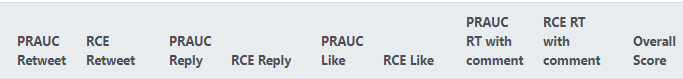

1.     model_list = [RUSBoostClassifier(),'',RUSBoostClassifier(),'']

2. prep_list = ['']*4

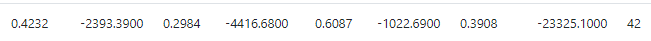
    
    

1. model_list = [RUSBoostClassifier(),'',RUSBoostClassifier(),'']

2. prep_list = ['']*4

3. train 1e6, val 1e5

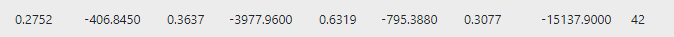


1. model_list = [RUSBoostClassifier(),'',RUSBoostClassifier(),'']

2. prep_list = ['']*4

3. train 1e6, val 1e5

4. using 'engaged_with_user_id' IT DOESNT FUCKING GO AS EXPECTED INITIALLY. NICE



In [8]:
train = {}
for i in range(4):
    train[i] = pd.read_pickle('train_{}.pkl'.format(i))

In [9]:
engagement = {}
label_list = ['reply','retweet', 'retweet_with_comment', 'like']

for i in range(len(label_list)):
    engagement[label_list[i]] = i
engagement

{'reply': 0, 'retweet': 1, 'retweet_with_comment': 2, 'like': 3}

# AQUI

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

tt = TwitterTransform()
tt.fit(df_og)
x_train, y_train = tt.transform(df_og)

for label in label_list:
    print(label)
    idx = engagement[label]

    xgb = XGBClassifier()
    xgb.fit(x_train, y_train[:,idx])

    gt = {}
    pred = {}
    for i in range(0,4):
        x_val,y_val = tt.transform(train[i])
        gt[i] = y_val[:,idx]
        y_pred = xgb.predict(x_val)
#         y_pred = np.zeros(gt[i].shape)
        pred[i] = y_pred
        prauc = compute_prauc(pred[i], gt[i])
        rce = compute_rce(pred[i], gt[i])
        roc = roc_auc_score( gt[i],pred[i])
        print('{}>>> PRAUC:{:.4f} RCE:{:.4f} ROCAUC:{:.4f}'.format(i,prauc, rce, roc))

reply
0>>> PRAUC:0.1043 RCE:-649.6263 ROCAUC:0.5000
1>>> PRAUC:0.0964 RCE:-645.9018 ROCAUC:0.5000
2>>> PRAUC:0.1133 RCE:-647.7562 ROCAUC:0.5000
3>>> PRAUC:0.1244 RCE:-648.1369 ROCAUC:0.5000
retweet
0>>> PRAUC:0.3438 RCE:-999.1989 ROCAUC:0.5036
1>>> PRAUC:0.3367 RCE:-998.7723 ROCAUC:0.5035
2>>> PRAUC:0.3337 RCE:-999.5774 ROCAUC:0.5035
3>>> PRAUC:0.3370 RCE:-1000.7722 ROCAUC:0.5035
retweet_with_comment
0>>> PRAUC:0.1289 RCE:-487.6652 ROCAUC:0.5001
1>>> PRAUC:0.0038 RCE:-487.5744 ROCAUC:0.5000
2>>> PRAUC:0.0038 RCE:-487.4402 ROCAUC:0.5000
3>>> PRAUC:0.0039 RCE:-489.3635 ROCAUC:0.5000
like
0>>> PRAUC:0.6692 RCE:-1664.1599 ROCAUC:0.6304
1>>> PRAUC:0.6668 RCE:-1672.6022 ROCAUC:0.6285
2>>> PRAUC:0.6679 RCE:-1665.7941 ROCAUC:0.6299
3>>> PRAUC:0.6677 RCE:-1665.2537 ROCAUC:0.6298


In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

tt = TwitterTransform()
tt.fit(df_og)
x_train, y_train = tt.transform(df_og)
x_val,y_val = tt.transform(train[0])

idx = engagement['like']
xgb = XGBClassifier()
xgb.fit(x_train, y_train[:,idx], eval_set=[(x_val, y_val[:,idx])], objective='binary:logistic', eval_metric='logloss')

np.unique( y_val[:,idx])

TypeError: fit() got an unexpected keyword argument 'objective'

In [30]:
for i in range(4):
    print_stats_df(train[i], name='Train_{}'.format(i))

GENERAL STATS Train_0
number of tweets: 1000000
number of unique media: 11
number of unique language: 65
number of unique EWUF users: 550983
number of unique EUF users: 857416

NUMBER OF ENGAGEMENTS Train_0
number of replies: 26725 0.026725
number of retweets: 111471 0.111471
number of retweet comments: 7577 0.007577
number of likes 438003 0.438003
------------------------------------------------------------

GENERAL STATS Train_1
number of tweets: 1000000
number of unique media: 10
number of unique language: 64
number of unique EWUF users: 552206
number of unique EUF users: 857431

NUMBER OF ENGAGEMENTS Train_1
number of replies: 26138 0.026138
number of retweets: 111214 0.111214
number of retweet comments: 7576 0.007576
number of likes 437455 0.437455
------------------------------------------------------------

GENERAL STATS Train_2
number of tweets: 1000000
number of unique media: 11
number of unique language: 64
number of unique EWUF users: 551302
number of unique EUF users: 85820

In [25]:
y = np.array([[1,2,3],[4,5,6]])
x = np.zeros(y.shape)
x

array([[0., 0., 0.],
       [0., 0., 0.]])

1. Rus (seed=24)


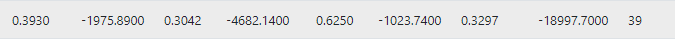


2. RUSBOOST

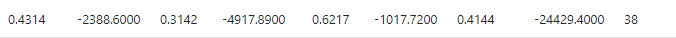


3. EasyEnsemble

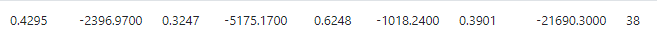

4. RandomForestClassifier

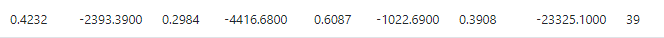

In [24]:
df = df_og.copy()

df['reply'] = df['reply_timestamp'].notna().astype(int)
df['retweet'] = df['retweet_timestamp'].notna().astype(int)
df['retweet_with_comment'] = df['retweet_with_comment_timestamp'].notna().astype(int)
df['like'] = df['like_timestamp'].notna().astype(int)

In [78]:
gp = df[['like','engaged_with_user_id']].groupby('engaged_with_user_id').sum()
gp['like'].value_counts(), gp['like'].value_counts().sum()

(0      292573
 1      225537
 2       24692
 3        7934
 4        3667
         ...  
 169         1
 173         1
 176         1
 177         1
 461         1
 Name: like, Length: 162, dtype: int64, 563629)

In [80]:
gp = df[['reply','engaged_with_user_id']].groupby('engaged_with_user_id').sum()
gp['reply'].value_counts()

0      538350
1       24048
2         832
3         196
4          74
5          37
6          29
7          19
8          12
9           8
11          5
12          4
10          3
13          2
18          2
29          1
14          1
15          1
16          1
17          1
20          1
21          1
105         1
Name: reply, dtype: int64

In [83]:
print_stats_df(df)

GENERAL STATS 
number of tweets: 1000000
number of unique media: 13
number of unique language: 65
number of unique EWUF users: 563629
number of unique EUF users: 656115

NUMBER OF ENGAGEMENTS 
number of replies: 27688 0.027688
number of retweets: 113136 0.113136
number of retweet comments: 7750 0.00775
number of likes 438804 0.438804
------------------------------------------------------------



In [85]:
df['reply'].sum()

27688

In [87]:
df['like'].sum()

438804

In [88]:
df['retweet'].sum()

113136

In [34]:
for label in ['reply','like','retweet','retweet_with_comment']:
    df_aux = df[df[label]==1]
    gp = df_aux[['engaged_with_user_follower_count',label]].groupby('engaged_with_user_follower_count').sum()
    print(label, gp,'\n')
type(gp)

reply                                   reply
engaged_with_user_follower_count       
1                                     5
2                                     5
3                                     7
4                                     9
5                                     9
...                                 ...
80753868                              1
82448793                              1
85578179                              2
108684804                             1
112787050                             2

[12827 rows x 1 columns] 

like                                   like
engaged_with_user_follower_count      
1                                   16
2                                   21
3                                   31
4                                   44
5                                   58
...                                ...
80753868                            19
82448793                           102
85578179                            51
108684804   

pandas.core.frame.DataFrame

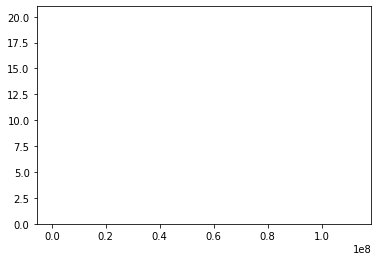

In [50]:
import matplotlib.pyplot as plt

# plt.hist(gp[label].values)
plt.bar(gp[label].index, gp[label].values)
plt.show()

In [36]:
df[['reply','tweet_id']]

,reply,tweet_id
0,0,BFB529DAB6D384EB83E899A72AB3830D
1,0,519078C7834E9642508F72A6C2D0F3B7
2,0,52AAE9E33EFAC8C478C57B31A9E31ED1
3,0,89C1298C55EB3D68E2784F0BFB69E6F8
4,0,D1F22992B720504FF058991B83A4C4D8
...,...,...
999995,0,4C83E289F6668FCF6B4ABF223769D7A8
999996,0,E05A382AEFE3F44518C98233CF439784
999997,0,7F6D93DF58E7B05DD51A81A99A0D6C65
999998,0,BD8344EA69DBB6C1F24895D7495F3FC0


In [112]:
for label in ['reply','like','retweet','retweet_with_comment']:
    gp = df[['tweet_id',label,'engaged_with_user_id']].groupby(['tweet_id','engaged_with_user_id']).sum()
gp

,,retweet_with_comment
tweet_id,engaged_with_user_id,
0000242C307E082B80CC48246A1FE876,C4B03ECE2011D18519216EE50925C1B9,0
0000438EEB381361629D89C28B6BD5DB,156D0C274B254E3839131031650812AC,0
00004564C2B60DB475C5B8E3F4EBD692,B4D9313A76CFFBB92E59500BB613E068,0
000069A5D8CFCD21D78B0E4E40876987,769927D8404E846E9977ACF60CE59C23,0
00006A569E4E2E52B21E09D849918930,62EED1F322A70E5CE99AB7A3080F7F28,0
...,...,...
FFFFD86AAD9059608B94849CB9D22E67,D146CFC9F2D1DDF0174065D5AA643030,0
FFFFDECA9EC26827966308943F9EFE4C,931145000636B383EDA48E191ABA1E67,0
FFFFE2011FDE820959722E6722BBF001,3EE399CEC490C4A5CB8FC98D0057F583,0


In [20]:
df[df[label]==1]

,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,enaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,reply,retweet,retweet_with_comment,like
32,101\t13999\t12845\t34396\t11088\t196\t10838\t4...,471B478434CC2272DB8A43DD23485965,40E2946B085B4BC33CCC7CD3330C8F38,NaN,EDA4C0CD3B03B111F22F553DEF7D9AB2,6B3DC7A7CA223895868C0176A2E958FC,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581142956,5E9AADA441950BE8DA0FE4EC7E3966B6,...,1295601797,False,1.581144e+09,NaN,NaN,NaN,1,0,0,0
77,101\t15729\t169\t24699\t11795\t12008\t10479\t1...,CC95B1F4B7749AA4E839D8E08710BEBD,AA02AD186E6AED68A7A45A71A5E6A96D,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581089266,564F317755D1C0F5E0A7DA430254E458,...,1562243684,False,1.581089e+09,1.581089e+09,NaN,1.581089e+09,1,1,0,1
115,101\t12882\t187\t22277\t10162\t10108\t27817\t1...,NaN,C11AF3705A431AE041DC14925C964627,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581278025,7DBB837CAF8CBE2FF02E4FB80B1F4383,...,1563828681,True,1.581418e+09,NaN,NaN,1.581418e+09,1,0,0,1
186,101\t137\t176\t12969\t11445\t106986\t11471\t10...,NaN,70116B6CD05B008CFCA8C1A484BE4DD2,NaN,NaN,NaN,TopLevel,1FFD2FE4297F5E70EBC6C3230D95CB9C,1581333606,94926D069053514D725F60AC321D0051,...,1540388888,True,1.581343e+09,NaN,NaN,1.581343e+09,1,0,0,1
234,101\t1861\t11274\t104939\t10157\t41674\t137\t1...,B8614BA6E1B1666C3B0896AD34B700AB\t02D3D97D3CBB...,31AF1C39C0F8EB08653DC214239927B8,Photo,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581436800,EF4D38362A83DACEDE3F5625E4BBC6C6,...,1564710344,False,1.581517e+09,NaN,NaN,NaN,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999912,101\t146\t16938\t112\t188\t21852\t10817\t119\t...,NaN,17314BEE2027DF0EC78B02CB414574D3,NaN,NaN,NaN,Quote,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581240009,4F4DA6CF9F95BD8E60E4432D80433DF9,...,1564769945,True,1.581248e+09,NaN,NaN,NaN,1,0,0,0
999930,101\t14516\t93161\t10107\t10105\t11758\t31624\...,NaN,78BED9FF76A39FF394E8850E8CA83912,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581375455,36EA625249AEE4C069372E5214D9BA6E,...,1434297209,True,1.581376e+09,NaN,NaN,1.581376e+09,1,0,0,1
999950,101\t13069\t10121\t10126\t12266\t10321\t169\t1...,NaN,A231F1480907639543CD22AB0AFDAAF4,NaN,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581218350,F6CF808BE66BD9470C5AB04E66B6DC9B,...,1513562387,False,1.581246e+09,1.581246e+09,NaN,1.581246e+09,1,1,0,1
999963,101\t56898\t137\t29956\t11282\t30742\t41025\t2...,NaN,58F360C2A790F02578E1FE26B44E99A8,NaN,NaN,NaN,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581084867,D6944BC5DBC7351AC125757B1EB60F87,...,1517066977,True,1.581085e+09,NaN,NaN,1.581085e+09,1,0,0,1
